# <center> Recommender System </center>

Constants

In [465]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 128
LEARNING_RATE = 1e-5
EPOCH = 45
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanAbsoluteError()

Log dir

In [524]:
LOG_NAME = "recommender-model-2"
DETAIL_DIR = os.path.join("log/detail/")
MODEL_DIR = os.path.join("log/model/savedmodel/")
PLOT_DIR = os.path.join("log/plot")
SUMMARY_DIR = os.path.join("log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [467]:
DATA_DIR = os.path.join("data/synt_data_filtered_optimized/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [468]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,price_category
0,1723,200630,197187,195951,"Drama,Romance,School,Supernatural",HIGH
1,82,793665,706740,824552,"Action,Adventure,Drama,Fantasy,Shounen",HIGH
2,296,114262,108897,81740,"Action,Comedy,Sci-Fi,Shounen",HIGH
3,127,673572,616509,786151,Sci-Fi,HIGH
4,137,151266,137612,70558,"Action,Comedy,Sci-Fi,Shounen",HIGH


In [469]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              6238 non-null   int64 
 1   insta_follower  6238 non-null   int64 
 2   tiktok          6238 non-null   int64 
 3   youtube         6238 non-null   int64 
 4   categories      6238 non-null   object
 5   price_category  6238 non-null   object
dtypes: int64(4), object(2)
memory usage: 292.5+ KB


In [470]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube
count,6238.000000,6.238000e+03,6.238000e+03,6238.000000
mean,3476.966656,3.362115e+04,2.999611e+04,27081.795608
std,2136.753019,7.256406e+04,6.687643e+04,62652.103843
min,1.000000,4.300000e+01,3.400000e+01,40.000000
25%,1610.250000,2.109250e+03,1.810250e+03,1564.000000
50%,3308.500000,7.567000e+03,6.637000e+03,5784.500000
75%,5285.750000,3.033725e+04,2.619625e+04,23340.500000
max,7387.000000,1.013917e+06,1.151584e+06,824552.000000


In [471]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.82
1,1,3,3,0.56
2,1,5,5,0.93
3,1,6,5,1.00
4,1,7,4,0.74


In [472]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409712 entries, 0 to 409711
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            409712 non-null  int64  
 1   inf_id            409712 non-null  int64  
 2   star_rating       409712 non-null  int64  
 3   sentiment_rating  409712 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.5 MB


In [473]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,409712.000000,409712.000000,409712.000000,409712.000000
mean,2446.166034,1079.041366,4.141360,0.777423
std,1438.816431,1149.462867,0.789167,0.161781
min,1.000000,1.000000,1.000000,0.000000
25%,1215.000000,261.000000,4.000000,0.680000
50%,2460.000000,640.000000,4.000000,0.790000
75%,3699.000000,1538.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [474]:
df_influencer.isnull().sum()

id                0
insta_follower    0
tiktok            0
youtube           0
categories        0
price_category    0
dtype: int64

In [475]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [476]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [477]:
follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

one_hot_price = df_inf_norm['price_category'].str.get_dummies()
df_inf_norm = pd.concat([df_inf_norm, one_hot_price], axis=1)
df_inf_norm = df_inf_norm.drop('price_category', axis=1)

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm.head()

,id,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,1723,0.197842,0.171207,0.237608,1,0,0,0,0,0,1,0,1,1,0,0,1
1,82,0.782762,0.613700,1.000000,1,0,0,1,1,0,1,1,0,0,0,1,0
2,296,0.112656,0.094536,0.099089,1,0,0,1,0,1,0,0,0,0,1,1,0
3,127,0.664312,0.535344,0.953426,1,0,0,0,0,0,0,0,0,0,1,0,0
4,137,0.149154,0.119472,0.085527,1,0,0,1,0,1,0,0,0,0,1,1,0


Remove some category

In [478]:
categories_count = df_inf_norm[df_inf_norm.columns[8:]].sum().sort_values(ascending=False)

column_name = list(categories_count.nlargest(10).index)
column_name
# plt.plot

['Comedy',
 'Sci-Fi',
 'Adventure',
 'Fantasy',
 'Drama',
 'Shounen',
 'Romance',
 'School',
 'Supernatural']

Combine star and sentiment rating

In [479]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.82,0.808
1,1,3,3,0.56,0.584
2,1,5,5,0.93,0.972
3,1,6,5,1.00,1.000
4,1,7,4,0.74,0.776
...,...,...,...,...,...
409707,4999,49,5,0.90,0.960
409708,4999,670,5,0.82,0.928
409709,4999,62,5,0.80,0.920
409710,4999,770,5,0.98,0.992


In [480]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2711,2711,2711,2711
2,9155,9155,9155,9155
3,58985,58985,58985,58985
4,195516,195516,195516,195516
5,143345,143345,143345,143345


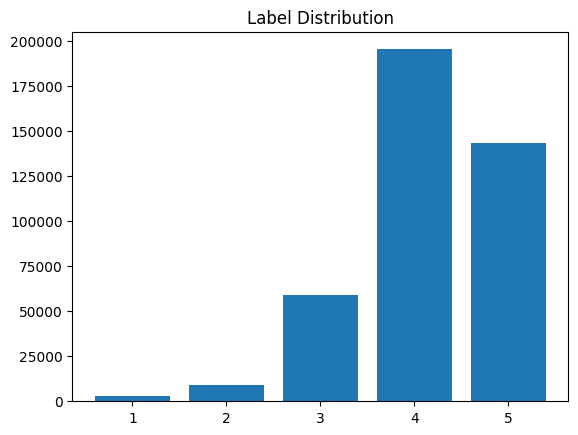

In [481]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [482]:
df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features.head()

,own_id,inf_id,combined_rating,id,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,1,1,0.808,1,0.125135,0.058950,0.080756,0,0,1,1,0,1,0,1,1,1,0,0,0
1,1,3,0.584,3,0.115435,0.074350,0.099125,0,0,1,0,0,1,0,0,0,0,0,0,0
2,1,5,0.972,5,0.123297,0.111566,0.163765,0,0,1,0,0,0,1,0,1,0,0,0,0
3,1,6,1.000,6,1.000000,1.000000,0.719537,1,0,0,0,0,0,0,0,0,0,0,0,1
4,1,7,0.776,7,0.558893,0.545334,0.766385,1,0,0,0,0,1,1,0,1,1,0,0,1


In [483]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm.head()

,id,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,1,0.360838,0.337075,0.392215,0.545000,0.000000,0.295500,0.309000,0.000000,0.374500,0.541500,0.216000,0.434500,0.406000,0.000000,0.000000,0.440500
1,2,0.158286,0.126934,0.160757,0.462334,0.032486,0.382869,0.376729,0.185119,0.417301,0.200170,0.251623,0.252754,0.207733,0.115550,0.288960,0.246675
2,3,0.248432,0.200828,0.268164,0.585529,0.000000,0.297176,0.262353,0.220471,0.530471,0.246471,0.239765,0.254706,0.198353,0.105529,0.154000,0.190706
3,4,0.324726,0.242903,0.280441,0.709951,0.000000,0.114829,0.626634,0.264683,0.389951,0.135805,0.326927,0.306244,0.095512,0.183707,0.312585,0.383220
4,5,0.243971,0.194405,0.252145,0.617409,0.000000,0.198000,0.285409,0.141818,0.434591,0.219909,0.177000,0.224273,0.265000,0.121682,0.135682,0.272682


##### Process feature and label

Influencer features

In [484]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,0.808,0.125135,0.058950,0.080756,0,0,1,1,0,1,0,1,1,1,0,0,0
1,0.584,0.115435,0.074350,0.099125,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0.972,0.123297,0.111566,0.163765,0,0,1,0,0,0,1,0,1,0,0,0,0
3,1.000,1.000000,1.000000,0.719537,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.776,0.558893,0.545334,0.766385,1,0,0,0,0,1,1,0,1,1,0,0,1


In [485]:
df_inf_features_pos = df_inf_features[df_inf_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_inf_features_neg = df_inf_features[df_inf_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_inf_features_pos

,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,0.125135,0.058950,0.080756,0,0,1,1,0,1,0,1,1,1,0,0,0
2,0.123297,0.111566,0.163765,0,0,1,0,0,0,1,0,1,0,0,0,0
3,1.000000,1.000000,0.719537,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.558893,0.545334,0.766385,1,0,0,0,0,1,1,0,1,1,0,0,1
5,0.450456,0.501621,0.765681,1,0,0,0,0,0,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.705322,0.350117,0.329269,1,0,0,1,0,0,0,0,0,1,1,0,0
409708,0.434266,0.417635,0.381867,1,0,0,1,0,0,0,0,0,0,1,0,0
409709,0.565006,0.331828,0.263791,1,0,0,1,0,0,1,0,0,0,1,0,0
409710,0.219159,0.202409,0.287501,1,0,0,1,0,0,0,0,0,0,1,0,0


In [486]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [487]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history, df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,1,1,0.808,1,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
1,1,3,0.584,1,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
2,1,5,0.972,1,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
3,1,6,1.000,1,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
4,1,7,0.776,1,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405


In [488]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,0.808,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
1,0.584,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
2,0.972,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
3,1.000,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405
4,0.776,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.0,0.0,0.4405


In [489]:
df_own_features_pos = df_own_features[df_own_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_own_features_neg = df_own_features[df_own_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_own_features_pos

,insta_follower,tiktok,youtube,HIGH,LOW,MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,School,Sci-Fi,Shounen,Supernatural
0,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.00,0.0,0.4405
2,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.00,0.0,0.4405
3,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.00,0.0,0.4405
4,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.00,0.0,0.4405
5,0.360838,0.337075,0.392215,0.545,0.0,0.2955,0.309,0.0,0.3745,0.5415,0.216,0.4345,0.406,0.00,0.0,0.4405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409707,0.454330,0.307437,0.299590,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,0.95,0.0,0.0000
409708,0.454330,0.307437,0.299590,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,0.95,0.0,0.0000
409709,0.454330,0.307437,0.299590,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,0.95,0.0,0.0000
409710,0.454330,0.307437,0.299590,0.950,0.0,0.0000,0.950,0.0,0.0000,0.2300,0.000,0.0000,0.240,0.95,0.0,0.0000


In [490]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [491]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.808
1    0.584
2    0.972
3    1.000
4    0.776
Name: combined_rating, dtype: float64

In [492]:
df_labels_pos = df_labels[df_labels > 0.6]
df_labels_neg = df_labels[df_labels <= 0.6]

df_labels_pos

0         0.808
2         0.972
3         1.000
4         0.776
5         0.920
          ...  
409707    0.960
409708    0.928
409709    0.920
409710    0.992
409711    1.000
Name: combined_rating, Length: 358181, dtype: float64

##### Generate train, validation, and test dataset

In [493]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(17,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(17,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [494]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.9)
VAL_SIZE = int(DATASET_SIZE * 0.05)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 368740 data
Validation dataset has 20485 data
Testing dataset has 20487 data


In [495]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE).repeat(REPEAT)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##### Generate train, validation, and test dataset (positive and negative)

In [496]:
SHUFFLE_BUFFER = 1000

dataset_pos = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_pos, "own_feature": df_own_features_pos}, df_labels_pos))
dataset_pos = dataset_pos.shuffle(SHUFFLE_BUFFER) 
dataset_neg = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_neg, "own_feature": df_own_features_neg}, df_labels_neg))
dataset_neg = dataset_neg.shuffle(SHUFFLE_BUFFER) 

print("Positive data:", dataset_pos.element_spec)
print("Count positive data:", dataset_pos.cardinality().numpy())

print("\nNegative data:", dataset_neg.element_spec)
print("Count negative data:", dataset_neg.cardinality().numpy())

Positive data: ({'inf_feature': TensorSpec(shape=(16,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(16,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count positive data: 358181

Negative data: ({'inf_feature': TensorSpec(shape=(16,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(16,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count negative data: 51531


In [497]:
# Generate training, validation, and testing data
POSITIVE_SIZE = dataset_pos.cardinality().numpy()
TRAIN_POS_SIZE = int(POSITIVE_SIZE * 0.9)
VAL_POS_SIZE = int(POSITIVE_SIZE * 0.05)
TEST_POS_SIZE = POSITIVE_SIZE - TRAIN_POS_SIZE - VAL_POS_SIZE

train_dataset_pos = dataset_pos.take(TRAIN_POS_SIZE)
val_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE).take(VAL_POS_SIZE)
test_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE + VAL_POS_SIZE).take(TEST_POS_SIZE)

print(f"Positive training dataset has {train_dataset_pos.cardinality().numpy()} data")
print(f"Positive validation dataset has {val_dataset_pos.cardinality().numpy()} data")
print(f"Positive testing dataset has {test_dataset_pos.cardinality().numpy()} data")

Positive training dataset has 322362 data
Positive validation dataset has 17909 data
Positive testing dataset has 17910 data


In [498]:
# Generate training, validation, and testing data
NEGATIVE_SIZE = dataset_neg.cardinality().numpy()
TRAIN_NEG_SIZE = int(NEGATIVE_SIZE * 0.5)
VAL_NEG_SIZE = int(NEGATIVE_SIZE * 0.25)
TEST_NEG_SIZE = NEGATIVE_SIZE - TRAIN_NEG_SIZE - VAL_NEG_SIZE

train_dataset_neg = dataset_neg.take(TRAIN_NEG_SIZE)
val_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE).take(VAL_NEG_SIZE)
test_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE + VAL_NEG_SIZE).take(TEST_NEG_SIZE)

print(f"Negative training dataset has {train_dataset_neg.cardinality().numpy()} data")
print(f"Negative validation dataset has {val_dataset_neg.cardinality().numpy()} data")
print(f"Negative testing dataset has {test_dataset_neg.cardinality().numpy()} data")

Negative training dataset has 25765 data
Negative validation dataset has 12882 data
Negative testing dataset has 12884 data


In [499]:
train_dataset = train_dataset_pos.concatenate(train_dataset_neg)
val_dataset = val_dataset_pos.concatenate(val_dataset_neg)
test_dataset = test_dataset_pos.concatenate(test_dataset_neg)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 348127 data
Validation dataset has 30791 data
Testing dataset has 30794 data


In [500]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Creating Model

Model consists of two neural networks that would be combined with Dot layer. The first neural network has influencer features as input and a vector as an output. The second one has owner features as input and a vector as an output. These two vectors will be combined with Dot layer and produces a single combined rating

In [501]:
VECTOR_SIZE = 150
# tf.random.set_seed(1)

model_influencer = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the influencer input and point to the base network
input_influencer = tf.keras.layers.Input(shape=(INFLUENCER_FEATURE_COUNT), name="inf_feature")
vi = model_influencer(input_influencer)
vi = tf.linalg.l2_normalize(vi, axis=1)

model_owner = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the owner input and point to the base network
input_owner = tf.keras.layers.Input(shape=(OWNER_FEATURE_COUNT), name="own_feature")
vo = model_owner(input_owner)
vo = tf.linalg.l2_normalize(vo, axis=1)

# compute the dot product of the two vectors vi and vo
output = tf.keras.layers.Dot(axes=1)([vi, vo])

# specify the inputs and output of the model
model = tf.keras.Model([input_influencer, input_owner], output)

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 16)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 16)]         0           []                               
                                                                                                  
 sequential_22 (Sequential)     (None, 150)          96342       ['inf_feature[0][0]']            
                                                                                                  
 sequential_23 (Sequential)     (None, 150)          192278      ['own_feature[0][0]']            
                                                                                           

In [502]:
import time

start_time = time.time()
model.compile(optimizer= OPTIMIZER, 
              loss=LOSS_FN,
              metrics=["mse", "mae"])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/20
2720/2720 [==============================] - 14s 5ms/step - loss: 0.1201 - mse: 0.0337 - mae: 0.1201 - val_loss: 0.1890 - val_mse: 0.0564 - val_mae: 0.1890
Epoch 2/20
2720/2720 [==============================] - 12s 4ms/step - loss: 0.0868 - mse: 0.0115 - mae: 0.0868 - val_loss: 0.1869 - val_mse: 0.0543 - val_mae: 0.1869
Epoch 3/20
2720/2720 [==============================] - 13s 5ms/step - loss: 0.0836 - mse: 0.0107 - mae: 0.0836 - val_loss: 0.1809 - val_mse: 0.0508 - val_mae: 0.1809
Epoch 4/20
2720/2720 [==============================] - 13s 5ms/step - loss: 0.0820 - mse: 0.0104 - mae: 0.0820 - val_loss: 0.1810 - val_mse: 0.0507 - val_mae: 0.1810
Epoch 5/20
2720/2720 [==============================] - 13s 5ms/step - loss: 0.0805 - mse: 0.0101 - mae: 0.0805 - val_loss: 0.1798 - val_mse: 0.0502 - val_mae: 0.1798
Epoch 6/20
2720/2720 [==============================] - 12s 4ms/step - loss: 0.0792 - mse: 0.0100 - mae: 0.0792 - val_loss: 0.1809 - val_mse: 0.0508 - val_mae: 0.180

In [503]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    else:
        plt.show()

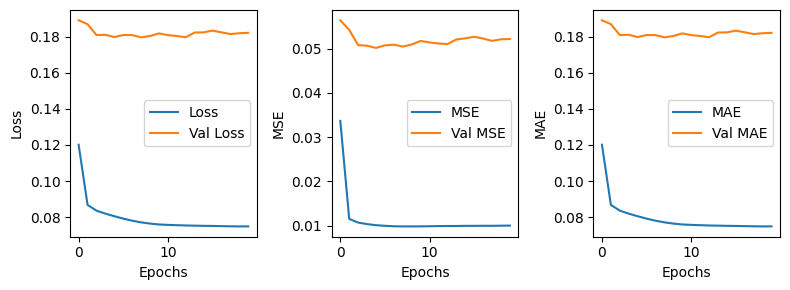

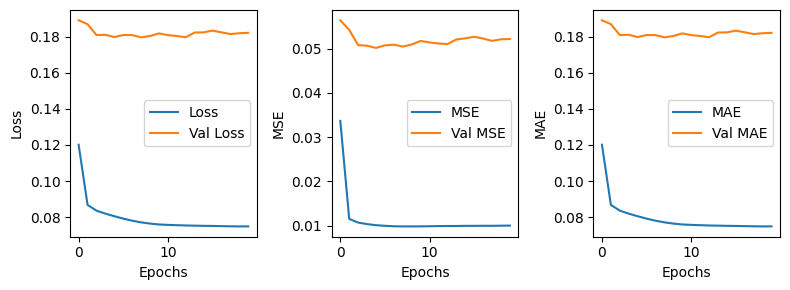

In [504]:
plot_history(history)
plot_history(history, save=True)


### Evaluation with test dataset

In [505]:
test_predict = model.predict(test_dataset)
test_predict

241/241 [==============================] - 1s 3ms/step


array([[0.5922565],
       [0.5706753],
       [0.5565812],
       ...,
       [0.5660612],
       [0.5265852],
       [0.5555165]], dtype=float32)

In [506]:
# Get real label
test_labels = np.array([])
for batch in test_dataset:
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_labels

array([0.796, 0.984, 0.972, ..., 0.592, 0.576, 0.584])

In [507]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

,predicted,real,error
0,0.592256,0.796,0.203744
1,0.570675,0.984,0.413325
2,0.556581,0.972,0.415419
3,0.581074,0.752,0.170926
4,0.572691,0.728,0.155309
...,...,...,...
30789,0.544366,0.388,0.156366
30790,0.564541,0.600,0.035459
30791,0.566061,0.592,0.025939
30792,0.526585,0.576,0.049415


In [508]:
compare_test[compare_test["error"] >= 3e-1]

,predicted,real,error
1,0.570675,0.984,0.413325
2,0.556581,0.972,0.415419
6,0.557106,0.928,0.370894
11,0.575960,0.984,0.408040
12,0.606343,0.964,0.357657
...,...,...,...
30615,0.546767,0.172,0.374767
30692,0.589795,0.216,0.373795
30716,0.565764,0.176,0.389764
30746,0.616342,0.240,0.376342


In [509]:
train_predict = model.predict(train_dataset)
train_predict

2720/2720 [==============================] - 6s 2ms/step


array([[0.60652626],
       [0.6174357 ],
       [0.58668005],
       ...,
       [0.57117575],
       [0.56723565],
       [0.56124586]], dtype=float32)

In [510]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

array([0.976, 1.   , 0.612, ..., 0.588, 0.404, 0.572])

In [511]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

,predicted,real,error
0,0.606526,0.976,0.369474
1,0.617436,1.000,0.382564
2,0.586680,0.612,0.025320
3,0.585173,0.760,0.174827
4,0.580519,0.924,0.343481
...,...,...,...
348122,0.529307,0.580,0.050693
348123,0.568943,0.588,0.019057
348124,0.571176,0.588,0.016824
348125,0.567236,0.404,0.163236


In [512]:
compare_train[compare_train["error"] >= 4e-1]

,predicted,real,error
5,0.569540,0.984,0.414460
6,0.573595,0.984,0.410405
8,0.584990,0.988,0.403010
15,0.560893,0.968,0.407107
33,0.567443,1.000,0.432557
...,...,...,...
347896,0.572330,0.160,0.412330
347941,0.577309,0.176,0.401309
348072,0.545288,0.128,0.417288
348086,0.569028,0.160,0.409028


In [513]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model\recommender-model-2\assets


In [514]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [515]:
import json
log = {
    "name": "recommender-model-1",
    "training_time": str(training_time),
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    "data_distribution": {
        "positive": POSITIVE_SIZE,
        "negative": NEGATIVE_SIZE,
        "training_pos": TRAIN_POS_SIZE,
        "training_neg": TRAIN_NEG_SIZE,
    },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [518]:
summary = model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 16)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 16)]         0           []                               
                                                                                                  
 sequential_22 (Sequential)     (None, 150)          96342       ['inf_feature[0][0]']            
                                                                                                  
 sequential_23 (Sequential)     (None, 150)          192278      ['own_feature[0][0]']            
                                                                                           

In [528]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()